# INSTALL and IMPORT

In [1]:
!pip install rouge_score
!pip install datasets transformers
!pip install py7zr
!pip install wandb
!pip install accelerate -U
!pip install transformers[torch]

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=a101b5464d9f21c559b0a7159a65e8e430cdd8a7a3d4eb16c9fdaf391d45418d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Att

In [2]:
import pandas as pd
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import zipfile
import os
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import accelerate
import re

# DATA CLEANSING AND LOADING

In [3]:
# Define the path to the zip file and the extraction directory
zip_file_path = ['dev.zip', 'test.zip', 'train.zip']
extraction_dir = 'enron_emails'

# Extract the zip file
for path in zip_file_path:
  with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# List the contents of the extraction directory
extracted_files = os.listdir(extraction_dir)
extracted_files

['dev', 'test', 'train']

In [4]:
# Define the dev, train and test directory

dev_dir = os.path.join(extraction_dir, 'dev')
train_dir = os.path.join(extraction_dir, 'train')
test_dir = os.path.join(extraction_dir, 'test')

# Print the count of files in each directory
dev_files = os.listdir(dev_dir)
print('Dev Files Count', len(dev_files))
train_files = os.listdir(train_dir)
print('Train Files Count', len(train_files))
test_files = os.listdir(test_dir)
print('Test Files Count', len(test_files))

Dev Files Count 1960
Train Files Count 14436
Test Files Count 1906


In [5]:
import pandas as pd

# Define a function to process each file and extract email body and subject line for DEV and TEST FILES

###### PREPROCESS ########
# Replacing multiple spaces to single space
# Remove special characters, as they do not influence subject line generation

def process_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    email_body_initial, subject_line = content.split('@subject\n', 1)
    email_body = re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', '', email_body_initial).strip())
    subjects = subject_line.replace("@ann0", "@subject\n").replace("@ann1", "@subject\n").replace("@ann2", "@subject\n")
    subject_0, subject_1, subject_2, subject_3 = subjects.split("@subject")
    return email_body.strip(), subject_0.strip(), subject_1.strip(), subject_2.strip(), subject_3.strip()

# Define a function to process each file and extract email body and subject line for TRAIN FILES

def process_train_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    email_body_initial, subject_line = content.split('@subject\n', 1)
    email_body = re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', '', email_body_initial).strip())
    return email_body.strip(), subject_line.strip()


In [6]:
# VALIDATE PROCESS FUNCTION

email_body, subject_line0, subject_line1, subject_line2, subject_line3 = process_file('enron_emails/dev/arnold-j_inbox_156.subject')

print(email_body)
print('\n\n', subject_line0)
print('\n\n', subject_line1)
print('\n\n', subject_line2)
print('\n\n', subject_line3)

John you may have already heard this but on Friday NYMEX increased margins for clearing brokers posting for Enron by 50 Also Soc Gen cancelled their margin line on Friday Warren wants to make it very clear that it was Soc Gen and not Fimat So far Fimat is not reducing its trading limit with us but is passing through the NYMEX requirement All of our brokers will have the right to do this and I expect them to do so Sarah


 Fimat/Soc Gen


 nymex increased margins


 nymex increased margins


 nymex margins increased


In [7]:
# VALIDATE PROCESS_TRAIN FUNCTION

email_body, subject_line = process_train_file('enron_emails/train/allen-p_inbox_64.subject')

print(email_body)
print('\n\n', subject_line)

To our IBS Customers that are still hanging in there We understand your continued frustration and express our sincerest apologies for our inability to give complete and accurate answers to your questions The problems that we are seeing are one of three 3 possibilities 1 You have entered your password incorrectly or what you thought was the correct password and been given the error message that you have exceeded your opportunities for today and you receive the message You have failed to correctly login three times today please try again tomorrow or contact the bank at 8303795236 to have your password reset This is the easiest problem to correct and we can fix this one quickly with you online on the phone Should you receive this message please call our Computer Department and ask for either myself Howard Gordon 8304011185 Christina Kirby 8304011189 or Lora Robles 8304011182 If you reach our voice mail or another employee please leave your Name Account and call back 2 You are not using th

In [8]:
# Process all DEV files and store the results in a DataFrame (Capture data in CSV for review)
fh_1 = open('dev_loader.txt', 'w')

data = []
for file_name in os.listdir(dev_dir):
    file_path = os.path.join(dev_dir, file_name)
    fh_1.write(file_path)
    email_body, subject_line, subject_line1, subject_line2, subject_line3 = process_file(file_path)
    fh_1.write('\n')
    fh_1.write(email_body)
    fh_1.write('\n')
    fh_1.write(subject_line)
    fh_1.write('\n')
    data.append((email_body, subject_line, subject_line1, subject_line2, subject_line3))

# Create a DataFrame from the processed data
df_dev = pd.DataFrame(data, columns=['email_body', 'subject_line', 'subject_line1', 'subject_line2', 'subject_line3' ])
fh_1.close()
# Display the DataFrame
print('Shape Of the Dev Dataset Dataframe :', df_dev.shape)
df_dev.head()

Shape Of the Dev Dataset Dataframe : (1960, 5)


,email_body,subject_line,subject_line1,subject_line2,subject_line3
0,Billy Lemmons I met on Friday regarding the An...,Analyst & Associates,new action for program - halting recruiting etc.,analyst and associate program actions,analyst and associate program
1,Whats up with this guy I guess he called Mr Pa...,NDR Energy,questions about that guy,what's wrong with this guy?,specific concerns
2,Sean Hows CO I hope you are doing well I know ...,November,need your dad and sister's email addresses please,i need your dad and sister's email address,need your father's email.
3,Jeff and Stan I lead the group responsible for...,Enron's plans on 2 projects,enron's plans & pending projects,it's important we know enron's plans!,los banos project and lodi project status request
4,If you are a participant in the Enron Corp Sav...,IMPORTANT-To All Domestic Employees who Partic...,enron corp. savings plan transitions!,enron corp.'s saving plan updates,important updates to enron corp. savings plan


In [72]:
# Process all TEST files and store the results in a DataFrame (Capture data in CSV for review)
fh_1 = open('test_loader.txt', 'w')

data = []
for file_name in os.listdir(test_dir):
    file_path = os.path.join(test_dir, file_name)
    fh_1.write(file_path)
    email_body, subject_line, subject_line1, subject_line2, subject_line3 = process_file(file_path)
    fh_1.write('\n')
    fh_1.write(email_body)
    fh_1.write('\n')
    fh_1.write(subject_line)
    fh_1.write('\n')
    data.append((email_body, subject_line, subject_line1, subject_line2, subject_line3))

# Create a DataFrame from the processed data
df_test = pd.DataFrame(data, columns=['email_body', 'subject_line', 'subject_line1', 'subject_line2', 'subject_line3' ])
fh_1.close()
# Display the DataFrame
print('Shape Of the TEST Dataset Dataframe :', df_test.shape)
df_test.head()

Shape Of the TEST Dataset Dataframe : (1906, 5)


,email_body,subject_line,subject_line1,subject_line2,subject_line3
0,John I am working with Gerald and Debra on imp...,Tennessee Gas Pipeling GISB,gisb with tenn. gas status,implementing gisb with tenn gas final execution,re: gisb with tenn. gas
1,At Richard Sanders request we ask that you fre...,Request for Freeze on E-Mail Destruction,freeze destruction of electronic mail,bid/ask litigation request,please freeze destruction of e-mails
2,Derek Could you call me sometime this week so ...,Annex A Letter,call me for annex a,request for contact regarding the annex a mail...,please call regarding annex a mail-out
3,This is a reminder that the ectenroncomeienron...,UPDATE: Supported Internet Email Addresses,reminder on update of email domains effective ...,deadline: email domains will be no longer avai...,email domains to be decommissioned
4,Ginny Please see the attached guaranty A clean...,Enron Corp. Guaranty,attached: guaranty for approval,please approve guaranty,attached guaranty.


In [10]:
# Process all TRAIN files and store the results in a DataFrame (Capture data in CSV for review)
data = []
for file_name in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file_name)
    email_body, subject_line = process_train_file(file_path)
    data.append((email_body, subject_line))

# Create a DataFrame from the processed data
df = pd.DataFrame(data, columns=['email_body', 'subject_line'])

# Display the DataFrame
print('Shape Of the TRAIN Dataset Dataframe : :', df.shape)
df.head()

Shape Of the TRAIN Dataset Dataframe : : (14436, 2)


,email_body,subject_line
0,Just a note to let you know that per my conver...,Bank of Montreal
1,Peter I cant recall if Ive sent you this overr...,Override letter for ABB
2,Esther Gary asked me to send this info to you ...,Customer trip for Gary Hanks
3,When Thursday October 25 2001 200 PM300 PM GMT...,Caithness +
4,Tana When you have the ETA amendment letter re...,TECO EnergySource Inc.


In [13]:
print(df.iloc[2]['email_body'])
print(df.iloc[2]['subject_line'])

Esther Gary asked me to send this info to you for the business trip that Ive invited him on Enron employees will be leaving at 1130am on Continental flight 1668 from Bush Intercontinental on Friday 8400 The return flight from Tampa will be Continental 1663 leaving Tampa at 320 pm on Sunday arriving in Houston at 429pm I believe that there are a couple of later flights on Friday around 130 and 330 if Gary needs to come in for a part of the day I will probably have to catch one of the later ones but Gary is welcome to go whenever he likes If you have any questions give me a call 36905 Daren
Customer trip for Gary Hanks


# DATA VISUALIZATION

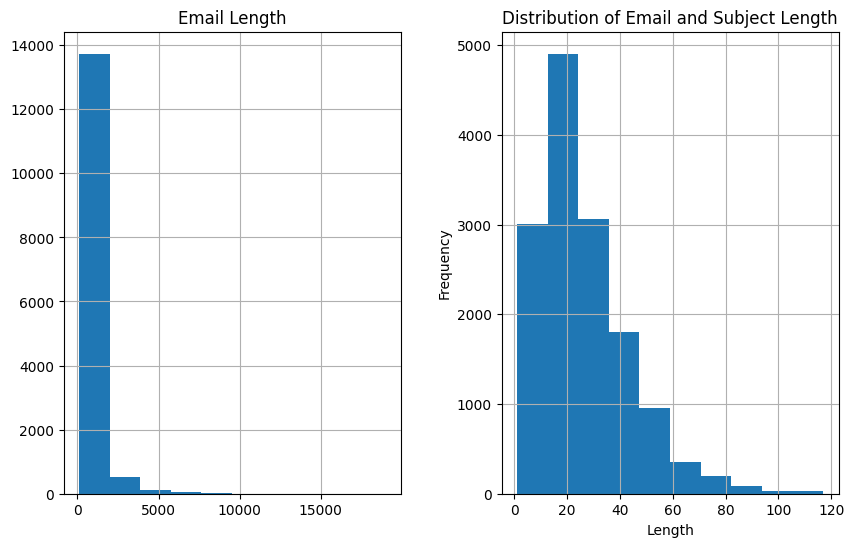

In [14]:
# TRAIN DATA
email_length = [len(email) for email in df['email_body']]
subject_length = [len(subject) for subject in df['subject_line']]

data = pd.DataFrame({'Email Length': email_length, 'Subject Length': subject_length})

data.hist(figsize=(10, 6), bins=10)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Email and Subject Length')
plt.show()

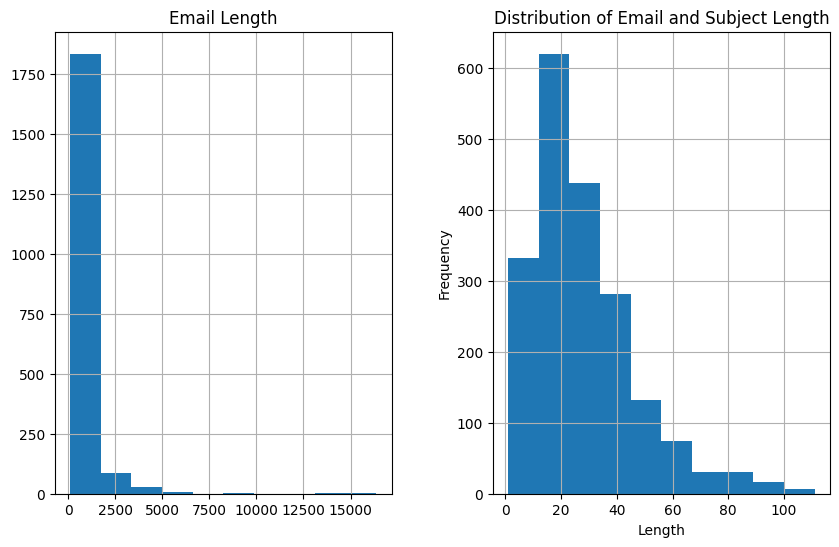

In [15]:
# DEV DATA
email_length = [len(email) for email in df_dev['email_body']]
subject_length = [len(subject) for subject in df_dev['subject_line']]

data = pd.DataFrame({'Email Length': email_length, 'Subject Length': subject_length})

data.hist(figsize=(10, 6), bins=10)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Email and Subject Length')
plt.show()

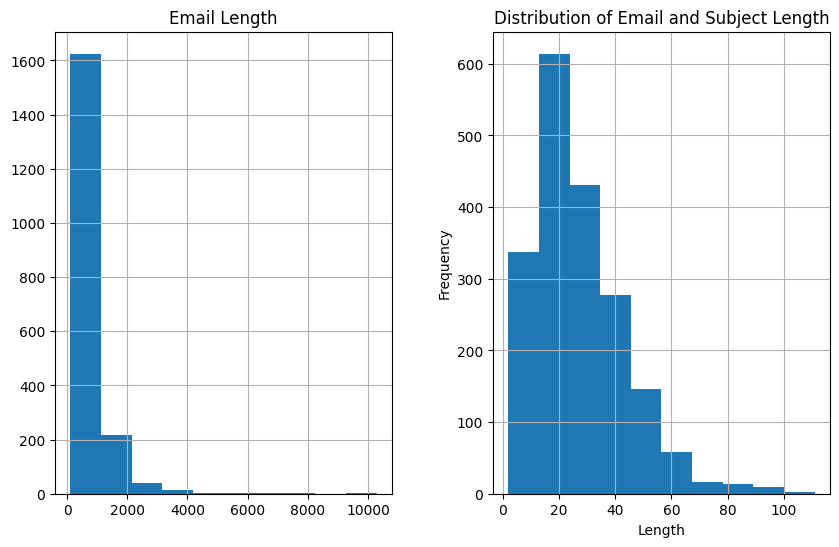

In [16]:
# TEST DATA
email_length = [len(email) for email in df_test['email_body']]
subject_length = [len(subject) for subject in df_test['subject_line']]

data = pd.DataFrame({'Email Length': email_length, 'Subject Length': subject_length})

data.hist(figsize=(10, 6), bins=10)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Email and Subject Length')
plt.show()

In [17]:
df['email_body'] = df['email_body'].apply(lambda x: x[:2500])
df_dev['email_body'] = df['email_body'].apply(lambda x: x[:2500])
df_test['email_body'] = df['email_body'].apply(lambda x: x[:2500])

# DATASET CREATION

In [18]:
# Creating Train, Dev and Test Dataset from the Dataframe

train_dataset = Dataset.from_pandas(df)
dev_dataset = Dataset.from_pandas(df_dev)
test_dataset = Dataset.from_pandas(df_test)

# Define the Dataset Dictionary

dataset_dict = DatasetDict({
    'train': train_dataset,
    'dev': dev_dataset,
    'test': test_dataset
})

In [24]:
id = 2
print("\n", df_dev["email_body"].iloc[id])
print("\n", df_dev["subject_line"].iloc[id])
print("\n", df_dev["subject_line1"].iloc[id])
print("\n", df_dev["subject_line2"].iloc[id])
print("\n", df_dev["subject_line3"].iloc[id])


 Esther Gary asked me to send this info to you for the business trip that Ive invited him on Enron employees will be leaving at 1130am on Continental flight 1668 from Bush Intercontinental on Friday 8400 The return flight from Tampa will be Continental 1663 leaving Tampa at 320 pm on Sunday arriving in Houston at 429pm I believe that there are a couple of later flights on Friday around 130 and 330 if Gary needs to come in for a part of the day I will probably have to catch one of the later ones but Gary is welcome to go whenever he likes If you have any questions give me a call 36905 Daren

 November

 need your dad and sister's email addresses please

 i need your dad and sister's email address

 need your father's email.


# LOAD THE MODEL

In [19]:
# Load the tokenizer and model
model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_l

# ZERO SHOT TESTING

In [29]:
pipe = pipeline("summarization", model= "facebook/bart-large-cnn")

# Function to dynamically adjust max_length
def zero_shot_testing(email_body, pipeline, min_length=3, length_penalty=2.0, num_beams=4):
    # Tokenize the input text
    input_tokens = pipeline.tokenizer(email_body, return_tensors='pt')
    input_length = input_tokens['input_ids'].shape[1]

    # Adjust max_length to be a certain percentage of the input length
    min_length = 3
    adjusted_max_length = max(min_length + 10, int(input_length * 0.6))  # Ensure a minimum length

    # Generate summary with dynamic max_length
    gen_kwargs = {
        "length_penalty": length_penalty,
        "num_beams": num_beams,
        "max_length": adjusted_max_length,
        "min_length": min_length
    }

    summary = pipeline(email_body, **gen_kwargs)[0]['summary_text']
    return summary

# Sample email body and subject line
email_body = df_test['email_body'].iloc[27]
subject_line = df_test['subject_line'].iloc[27]

# Summarize the email body
summary = zero_shot_testing(email_body, pipe)

print("Email Body:", email_body)
print("\n")
print("Subject Line:", subject_line)
print("\n")
print("Generated Summary:", summary)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Email Body: Hi Judy How are you I sent Ingrid an email and she told me that you are still at Enron Thats good I tried to call you at work but the girl that answered the phone said that you were on vacation today How are the kids and Rob I think about you all of the time Ingrid told me that she told you that I got married It isnt Tod it is James Johnson that I dated in high school We could have saved each other a lot of heart ache and just stayed together He is really sweet He has 3 boys so now there are 4 boys in my house I am real outnumbered But its fun Are you still working parttime or fulltime There is so much to talk about we need to get together for lunch or something Maybe we could meet somewhere one day let me know My phone numbers are Home 2818073186 and work 7132154473 And now you have my email address Talk to you soon Laurie


Subject Line: Latest Marketing List


Generated Summary: Laurie writes to her ex-boyfriend from high school. She wants to know if he is still at Enron

# DATA COLLATOR & ENCODING

In [21]:
# This Function will get a batch or email bodies, tokenize them and return the encodings (input_ids, attention_masks and labels)

def get_feature(batch):
  encodings = tokenizer(batch['email_body'], text_target =batch['subject_line'], max_length=1024, truncation=True)

  encodings = {'input_ids' : encodings['input_ids'],
               'attention_mask' : encodings['attention_mask'],
               'labels' : encodings['labels']}

  return encodings

In [22]:
dataset_dict # Printing to ensure dataset is defined correctly

DatasetDict({
    train: Dataset({
        features: ['email_body', 'subject_line'],
        num_rows: 14436
    })
    dev: Dataset({
        features: ['email_body', 'subject_line', 'subject_line1', 'subject_line2', 'subject_line3'],
        num_rows: 1960
    })
    test: Dataset({
        features: ['email_body', 'subject_line', 'subject_line1', 'subject_line2', 'subject_line3'],
        num_rows: 1906
    })
})

In [23]:
dataset_pt = dataset_dict.map(get_feature, batched=True) # map function will apply the encodings for all the records in the dataset passed

Map:   0%|          | 0/14436 [00:00<?, ? examples/s]

Map:   0%|          | 0/1960 [00:00<?, ? examples/s]

Map:   0%|          | 0/1906 [00:00<?, ? examples/s]

In [24]:
dataset_pt # After running the Map , checnking the shape to see if the additional columns are added

DatasetDict({
    train: Dataset({
        features: ['email_body', 'subject_line', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14436
    })
    dev: Dataset({
        features: ['email_body', 'subject_line', 'subject_line1', 'subject_line2', 'subject_line3', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1960
    })
    test: Dataset({
        features: ['email_body', 'subject_line', 'subject_line1', 'subject_line2', 'subject_line3', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1906
    })
})

In [25]:
columns = ['input_ids', 'labels', 'attention_mask']
dataset_pt.set_format(type='torch', columns=columns)

In [26]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [27]:
train_test_split = dataset_pt['train'].train_test_split(test_size=0.2)

In [28]:
train_test_split

DatasetDict({
    train: Dataset({
        features: ['email_body', 'subject_line', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 11548
    })
    test: Dataset({
        features: ['email_body', 'subject_line', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2888
    })
})

In [29]:
dataset_dict['train'] = train_test_split['train']
dataset_dict['eval'] = train_test_split['test']

In [32]:
import accelerate
from transformers import TrainingArguments, Trainer
import wandb
wandb.init(project="BART_email-subject-line-generation")

training_args = TrainingArguments(
    output_dir = 'bart_summarizer',
    num_train_epochs = 5,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_steps = 10,
    eval_strategy = 'steps',
    eval_steps = 500,
    save_steps = 5e5,
    report_to = 'wandb',
    learning_rate = 1e-5
)

trainer = Trainer(
    model = model,
    args = training_args,
    tokenizer = tokenizer,
    train_dataset = dataset_dict['train'],
    eval_dataset = dataset_dict['eval'],
    data_collator = data_collator
)

trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss
500,2.757900,3.060303
1000,2.541700,2.949572
1500,1.880900,2.753258
2000,1.787400,2.750337
2500,1.801700,2.677149
3000,1.717100,2.752264
3500,1.780700,2.803409
4000,1.752800,2.786363
4500,1.314000,2.881327
5000,1.472200,2.859555


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


TrainOutput(global_step=7220, training_loss=1.8614786453194234, metrics={'train_runtime': 4839.0488, 'train_samples_per_second': 11.932, 'train_steps_per_second': 1.492, 'total_flos': 3.865935146817946e+16, 'train_loss': 1.8614786453194234, 'epoch': 5.0})

# SAVE MODEL AND VALIDATE

In [33]:
# Saving the Model

trainer.save_model('bart_summarizer_saved')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [55]:
model_name = "bart_summarizer_saved"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [56]:
# Email summarization

pipe = pipeline("summarization", model="bart_summarizer_saved")

# Function to dynamically adjust max_length
def summarize_email(email_body, pipeline, min_length=3, length_penalty=2.0, num_beams=4):
    # Tokenize the input text
    input_tokens = pipeline.tokenizer(email_body, return_tensors='pt')
    input_length = input_tokens['input_ids'].shape[1]

    # Adjust max_length to be a certain percentage of the input length
    min_length = 3
    adjusted_max_length = max(min_length + 10, int(input_length * 0.6))  # Ensure a minimum length

    # Generate summary with dynamic max_length
    gen_kwargs = {
        "length_penalty": length_penalty,
        "num_beams": num_beams,
        "max_length": adjusted_max_length,
        "min_length": min_length
    }

    summary = pipeline(email_body, **gen_kwargs)[0]['summary_text']
    return summary

# Sample email body and subject line
email_body = df_dev['email_body'].iloc[1227]
subject_line = df_dev['subject_line'].iloc[1227]

# Summarize the email body
summary = summarize_email(email_body, pipe)

print("Email Body:", email_body)
print("\n")
print("Subject Line:", subject_line)
print("\n")
print("Generated Summary:", summary)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Email Body: If you are planning to attend the December 6 2001 Drafting Committee meeting here in Columbus Ohio and have not already made your hotel reservations please do so as soon as possible in order to get the discount AEP rate Their discount rate for AEP is 92 per night plus tax Apparently they only have so many rooms with the discount rate The hotel is Courtyard by Marriott Downtown 35 W Spring St Columbus Ohio 43215 614 2283200 I will be checking other hotels in the area to find out about discount rates and forward to you the information Please forward any names of individuals that you know will be attending the meeting who are not listed Please contact me if you have any questions Thank you


Subject Line: PSEG capacity


Generated Summary: Hotel Reservations for the AEP Drafting Committee Meeting


In [35]:
!zip -r /content/bart_summarizer_saved.zip -r /content/bart_summarizer_saved

  adding: content/bart_summarizer_saved/ (stored 0%)
  adding: content/bart_summarizer_saved/tokenizer_config.json (deflated 75%)
  adding: content/bart_summarizer_saved/tokenizer.json (deflated 72%)
  adding: content/bart_summarizer_saved/generation_config.json (deflated 48%)
  adding: content/bart_summarizer_saved/merges.txt (deflated 53%)
  adding: content/bart_summarizer_saved/training_args.bin (deflated 51%)
  adding: content/bart_summarizer_saved/model.safetensors (deflated 7%)
  adding: content/bart_summarizer_saved/vocab.json (deflated 59%)
  adding: content/bart_summarizer_saved/config.json (deflated 61%)
  adding: content/bart_summarizer_saved/special_tokens_map.json (deflated 52%)


# ROUGE SCORE

In [73]:
df_rouge = df_test

In [ ]:
df_rouge

In [93]:
from datasets import load_metric

pipe = pipeline("summarization", model="bart_summarizer_saved")

# Load the ROUGE metric
rouge = load_metric("rouge")

def summarize_email(email_body, pipe):
    # Tokenize the input text
    input_tokens = pipe.tokenizer(email_body, return_tensors='pt', truncation=False)
    input_length = input_tokens['input_ids'].shape[1]

    # Adjust max_length to be a certain percentage of the input length
    adjusted_max_length = max(3, int(input_length * 0.6))  # Ensure a minimum length
    # Generate summary with dynamic max_length
    gen_kwargs = {
        "length_penalty": 2.0,
        "num_beams": 5,
        "max_length": adjusted_max_length,
        "min_length": 3
    }

    summary = pipe(email_body, **gen_kwargs)[0]['summary_text']
    return summary

# Generate summaries for the test dataset
def generate_summary(text):
    email_body = re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', '', text).strip())
    try:
        summary = summarize_email(email_body, pipe)
        #print(summary)
    except:
        summary = "Error"
        #print(email_body)
    return summary


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [94]:
email_text = """John,   I am working with Gerald and Debra on implementing a GISB with Tenn. Gas.
Currently, we have worked out every detail.
Their legal department is reviewing our special provisions and then they are supposed to sign two copies of the agreement and send them to us for final execution.
If you have any questions with respect to this Agreement, please do not hesitate to contact me.
Best Regards,"""

response = generate_summary(email_text)
print(response)

Tenn Gas GISB


In [95]:
df_rouge.drop(['generated_summary'], axis=1, inplace=True) # Drop the 'generated_summary' column if it exists

In [96]:
# Apply the function to the email_body column and create a new column 'generated_summary'
df_rouge['generated_summary'] = df_rouge['email_body'].apply(generate_summary)

In [97]:
from rouge_score import rouge_scorer

df_rouge.to_csv()

emailbd = df_rouge['email_body'].tolist()
preds = df_rouge['generated_summary'].tolist()
temp = df_rouge[['subject_line', 'subject_line1', 'subject_line2', 'subject_line3']]
labels = temp.values.tolist()
#print(len(labels))
#print(len(preds))
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Generate predictions and calculate ROUGE scores
all_rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

# Rouge expects input as list of strings for predictions and references
for i in range(len(labels)):
  for lbl in labels[i]:
    #rouge_output = rouge.compute(predictions=preds, references=lbl, use_stemmer=True)
    scores = scorer.score(preds[i], lbl)
    for key in all_rouge_scores.keys():
      all_rouge_scores[key].append(scores[key].fmeasure)


avg_rouge_scores = {key: sum(scores)/len(scores) for key, scores in all_rouge_scores.items()}
print("Average ROUGE Scores:", avg_rouge_scores)

Average ROUGE Scores: {'rouge1': 0.3173112908268027, 'rouge2': 0.1545315218237054, 'rougeL': 0.3026567230942907}


# Saving to Hugging Face Spaces

In [ ]:
import huggingface_hub

model_name = "bart_for_email_summarization_enron"  # Choose a name for your model
model.push_to_hub(model_name)
tokenizer.push_to_hub(model_name)

# QUANTIZATION and COMPRESSION

In [ ]:
import torch.nn.utils.prune as prune
import torch.nn as nn

# Define a helper function to prune a layer
def apply_pruning_to_layer(layer, amount=0.4):
    prune.l1_unstructured(layer, name='weight', amount=amount)
    prune.remove(layer, 'weight')

# Prune all the linear layers in the model
for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
        apply_pruning_to_layer(module)

# Verify the size reduction
print(f"Model size after pruning: {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters")


Model size after pruning: 406290432 parameters


In [ ]:
import torch.quantization

# Set the model to evaluation mode
model.eval()

# Apply dynamic quantization to the model
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

# Verify the size reduction
print(f"Model size after quantization: {sum(p.numel() for p in quantized_model.parameters() if p.requires_grad)} parameters")


Model size after quantization: 53698560 parameters


In [ ]:
import os

# Directory to save the pruned and quantized model
output_dir = "pruned_quantized_bart"
os.makedirs(output_dir, exist_ok=True)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

# Save the model state_dict (PyTorch)
torch.save(quantized_model.state_dict(), os.path.join(output_dir, "quantized_model.pth"))

# Save the model configuration
quantized_model.config.save_pretrained(output_dir)

print(f"Pruned and quantized model saved to {output_dir}")


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


Pruned and quantized model saved to pruned_quantized_bart


In [ ]:
!zip -r /content/pruned_quantized_bart.zip -r /content/pruned_quantized_bart

  adding: content/pruned_quantized_bart/ (stored 0%)
  adding: content/pruned_quantized_bart/config.json (deflated 61%)
  adding: content/pruned_quantized_bart/tokenizer.json (deflated 72%)
  adding: content/pruned_quantized_bart/vocab.json (deflated 59%)
  adding: content/pruned_quantized_bart/merges.txt (deflated 53%)
  adding: content/pruned_quantized_bart/special_tokens_map.json (deflated 52%)
  adding: content/pruned_quantized_bart/tokenizer_config.json (deflated 75%)
  adding: content/pruned_quantized_bart/quantized_model.pth (deflated 47%)


# ROUGH WORK

In [ ]:
import re
sample_string = """=                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                    IntercontinentalExchange                =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                             =20                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                    Firm Physical Natural Gas Price Bulletin                =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                             =20                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                    For Natural Gas Delivered on Thursday, November  29, 200= 1                                                                          =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                   =20                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                    (Trade Date of Wednesday, November  28, = 2001)                                                                      =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                           =20 Click here to access index history .
=                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                     =20                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                    * volume represents sell-side only *    =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                           =20 Region     HubHighLowWtd Avg IndexChange ($)Vol (mmBtu)Hub Name LOUISIANA     ANR SE          $2.4200          $2.2800          $2.3548+    .4895    =      228,200American Natural Resources Pipeline Co. - SE  Transmission Pool=     Columbia Onshore          $2.4400          $2.2600          $2.3683+   =  .6257         267,600Columbia Gulf Transmission Co. - Onshore Pool     Hen= ry Hub          $2.5500          $1.9750          $2.3571+    .4581       1= ,044,800Henry Hub tailgate - Louisiana     NGPL LA          $2.5000        =   $2.2700          $2.3806+    .4607         210,500Natural Gas Pipeline Co= .
of America, Louisiana Pool     Tenn 500L          $2.3900          $2.110= 0          $2.2778+    .4366         251,400Tennessee Gas Pipeline Co.-Zone=  L, 500 Leg Pool     Tenn 800L          $2.3800          $2.1100          $= 2.2764+    .5072         197,800Tennessee Gas Pipeline Co.-Zone L, 800 Leg = Pool     TETCO ELA          $2.4000          $2.2500          $2.3196+    .= 4865         249,100Texas Eastern - East LA     TETCO WLA          $2.3600 =          $2.1200          $2.3047+    .4824         169,400Texas Eastern - = West LA     Transco 65          $2.4025          $2.1200          $2.2974+ =    .4937         375,600Transco - Station 65     Trunkline ELA          $2.= 4100          $2.3000          $2.3509+    .5316          54,500Trunkline G= as Company - East Louisiana Pool     TxGas SL          $2.4400          $2.= 0050          $2.3463+    .5026         185,400Texas Gas Transmission Corp.=
"""

# Function to clean up the string
def clean_string(text):
    # Replace multiple whitespace characters with a single space
    cleaned_text = re.sub(r'\s+', ' ', text).strip()
    return cleaned_text

# Clean the sample string
cleaned_string = clean_string(sample_string)

print("Original String:")
print(repr(sample_string))
print("\nCleaned String:")
print(repr(cleaned_string))